In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
from mppi.Utilities import Constants as Const
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema
import os

h_red = Const.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
h = Const.Planck_ev_ps*1e3 # h in eV*fs

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32
cpus_per_task=1
omp_num_threads=1
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #fastnodes
                memory='124000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
ypp_code = C.YamboCalculator(rr,executable='ypp',activate_BeeOND=True) 
ypp_code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '124000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'pre_processing': '/home/dalessandro/module_script/yambo_module',
 'executable': 'ypp',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

# Analysis of the band structure of the WSe$_2$

We compute the dft band structure using the ypp post processing starting from the uniform sampling od the BZ.

Valence bands are the 51 and 52.

Bulk Wse2 is assumed to be an indirect semiconductor with a gap of 1.25 eV (https://www.2dsemiconductors.com/tungsten-diselenide-wse).

We use this information to compute the value of the scissor for each k sampling used. Note that within DFT approach the top
of valence band is at $\Gamma$ whereas the physical indirect gap is obtained from K to the minum of the K valley
of the conduction band. So we compute the same quantity in the DFT framework to perform a comparison and set the value of
the scissor correction.

In [4]:
run_path = 'BANDS'
kpoints = ['12x12x3'] #['9x9x1','12x12x3','15x15x4','18x18x5']

In [5]:
for k in kpoints:
    source_dir = 'DFT_analysis/kpoints_%s-nbnds_60.save'%k
    run_dir = os.path.join(run_path,k)
    Tools.init_yambo_dir(input_dir=source_dir,yambo_dir=run_dir)

Create the folder path BANDS/12x12x3
Executing command: cd BANDS/12x12x3; p2y -I ../../DFT_analysis/kpoints_12x12x3-nbnds_60.save
Build the r_setup in the yambo_dir path BANDS/12x12x3


In [6]:
band_range = [47,56]
bands_step = 50

# in crystal coordinates
G = [0.,0.,0.]
Kp = [1./3.,1./3.,0.]
Mp = [0.,0.5,0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path
path = [G,Mp,Kp,G]
#GfnQP_E = {'9x9x1' :  [0.25,1.,1.], '12x12x3' : [0.18,1.,1.], '16x16x4' : [0.0,1,1.2]}

study = D.Dataset(num_tasks=2,skip=True)

for k in kpoints:
    run_dir = os.path.join(run_path,k)
    inp = I.YamboInput(args='ypp -s b -V qp',folder=run_dir,filename='ypp.in')
    inp.set_array_variables(BANDS_bands=band_range,BANDS_steps=bands_step,BANDS_kpts=path)
    #inp.set_array_variables(GfnQP_E=GfnQP_E[k])
    inp.set_scalar_variables(cooIn='rlu',cooOut='rlu')
    inp['variables']['INTERP_mode'] = 'BOLTZ'
    inp['variables']['INTERP_Shell_Fac'] = [20,'']
    inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
    inp['variables']['GfnQP_INTERP_shells'] = [20,'']
    idd = 'ypp_bands_dft_boltz_%s'%k
    study.append_run(run_dir=run_dir,id=idd,input=inp,runner=ypp_code) 

Initialize a Dataset with 2 parallel tasks


In [7]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'BANDS/12x12x3',
 'num_tasks': 2,
 'verbose': True,
 'skip': True,
 'input': {'args': 'ypp -s b -V qp',
  'folder': 'BANDS/12x12x3',
  'filename': 'ypp.in',
  'arguments': [],
  'variables': {'INTERP_Shell_Fac': [20, ''],
   'INTERP_NofNN': [1.0, ''],
   'OutputAlat': [0.0, ''],
   'BANDS_steps': [50, ''],
   'GfnQP_INTERP_NN': [1.0, ''],
   'GfnQP_INTERP_shells': [20, ''],
   'GfnQP_Wv_E': [0.0, 'eV'],
   'GfnQP_Wv_dos': [0.0, 'eV'],
   'GfnQP_Wc_E': [0.0, 'eV'],
   'GfnQP_Wc_dos': [0.0, 'eV'],
   'PROJECT_mode': 'none',
   'INTERP_mode': 'BOLTZ',
   'cooIn': 'rlu',
   'cooOut': 'rlu',
   'CIRCUIT_E_DB_path': 'none',
   'GfnQPdb': 'none',
   'GfnQP_DbGd_INTERP_mode': 'BOLTZ',
   'GfnQP_Z': [(1+0j), ''],
   'BANDS_bands': [[47, 56], ''],
   'GfnQP_E': [[0.0, 1.0, 1.0], ''],
   'GfnQP_Wv': [[0.0, 0.0, 0.0], ''],
   'GfnQP_Wc': [[0.0, 0.0, 0.0], ''],
   'BANDS_kpts': [[[0.0, 0.0, 0.0],
     [0.0, 0.5, 0.0],
     [0.3333333333333333, 0.3333333333333333, 0.

In [8]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 ypp -F ypp_bands_dft_boltz_12x12x3.in -J ypp_bands_dft_boltz_12x12x3 -C ypp_bands_dft_boltz_12x12x3
slurm submit:  cd BANDS/12x12x3 ; sbatch job_ypp_bands_dft_boltz_12x12x3.sh
computation ypp_bands_dft_boltz_12x12x3 is running...
computation ypp_bands_dft_boltz_12x12x3 ended
Task [0] ended 
 


We include bands from 47 to 56, so in this range valence bands are 4 and 5 (bands index starts from 0 in the python array)

In [9]:
results[0]

{'output': {'bands_interpolated': 'BANDS/12x12x3/ypp_bands_dft_boltz_12x12x3/o-ypp_bands_dft_boltz_12x12x3.bands_interpolated',
  'spin_factors_UP_interpolated': 'BANDS/12x12x3/ypp_bands_dft_boltz_12x12x3/o-ypp_bands_dft_boltz_12x12x3.spin_factors_UP_interpolated',
  'spin_factors_DN_interpolated': 'BANDS/12x12x3/ypp_bands_dft_boltz_12x12x3/o-ypp_bands_dft_boltz_12x12x3.spin_factors_DN_interpolated',
  'magnetization_x_interpolated': 'BANDS/12x12x3/ypp_bands_dft_boltz_12x12x3/o-ypp_bands_dft_boltz_12x12x3.magnetization_x_interpolated',
  'magnetization_y_interpolated': 'BANDS/12x12x3/ypp_bands_dft_boltz_12x12x3/o-ypp_bands_dft_boltz_12x12x3.magnetization_y_interpolated',
  'magnetization_z_interpolated': 'BANDS/12x12x3/ypp_bands_dft_boltz_12x12x3/o-ypp_bands_dft_boltz_12x12x3.magnetization_z_interpolated'},
 'report': 'BANDS/12x12x3/ypp_bands_dft_boltz_12x12x3/r-ypp_bands_dft_boltz_12x12x3_electrons_bnds',
 'dft': 'BANDS/12x12x3/SAVE/ns.db1'}

Text(0.5, 1.0, 'WSe$_2$ bands k_12x12x3')

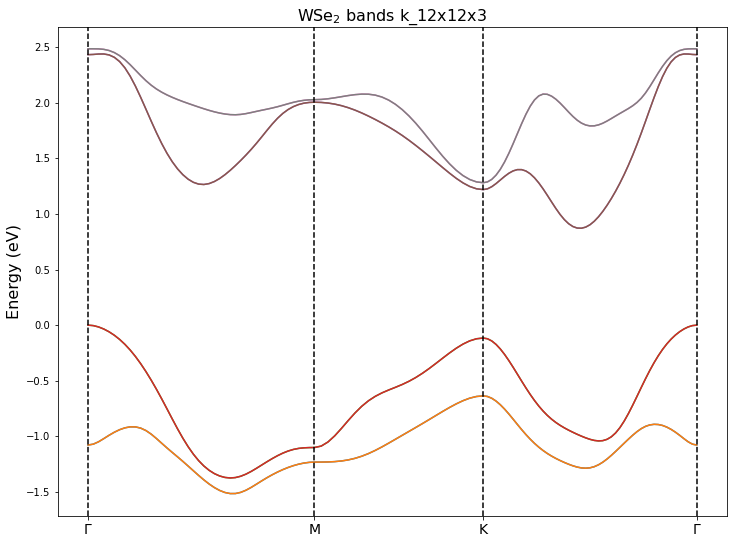

In [9]:
ind = 0

bands = U.BandStructure.from_Ypp(results[ind],high_sym,suffix='bands_interpolated')
fig, ax = plt.subplots(figsize=(12, 9))
bands.plot(plt,selection=[2,3,4,5,6,7,8,9],linestyle='-')
ax.set_ylabel('Energy (eV)',size=16)
plt.title('WSe$_2$ bands k_%s'%kpoints[ind],size=16)

We compute the (indirect) gap

In [76]:
bands.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'M'],
 [0.0, 1.3440817278312105, 0.872677740669527, 0.49999994])

In [77]:
path = bands.get_path()
ind_K = np.where(path == bands.get_high_sym_positions()[1][2])[0][0]
ind_K

68

In [78]:
val,cond = bands.bands[5],bands.bands[6]
gap = min(cond)-val[ind_K]
direct_gap = cond[ind_K]-val[ind_K]
gap,direct_gap

(0.98902288, 1.335694287)

In [79]:
exp_gap = 1.25
scissor = exp_gap-gap
scissor

0.26097711999999995

Performing this analysis for all the k samplings we build the dictionary we observe that the value

scissor = 0.261

reproduce the experimental gap for all the k samplings.

In [80]:
scissor = 0.261 # eV

Using this value we obtain a direct gap of

In [81]:
direct_gap+scissor

1.596694287

and the optical transition int the K valley given by 

In [82]:
cond_min_ind = argrelextrema(-cond,np.greater,order=3)[0]
cond_min = cond[cond_min_ind]
cond_min_ind,cond_min

(array([22, 68, 91]), array([1.26458645, 1.21940041, 0.872729  ]))

The minimum in the K valley corresponds to cond_min_ind=91

In [83]:
gap_Kvalley = scissor+cond[91]-val[91]
gap_Kvalley

2.129538856

so the gap in the K valley is 2.12 eV.

__We repeat the computation in the 12x12x1 using the same parameters of the bands computation in the RT case.__

In [37]:
k = kpoints[0]
band_range = [49,56]
bands_step = 50
scissor = 0.261 # eV

# The coordinates of the high sym points are provided in crystal coordinates
# to match the 'rlu' in the ypp input
G = [0.,0.,0.]
K = [1./3.,1./3.,0.]
M = [0.5,0.,0.]
high_sym = {'G':G,'K':K,'M':M} # useful to label the high-sym point on the path

study = D.Dataset(num_tasks=1,skip=True)

run_dir = os.path.join(run_path,k)
inp = I.YamboInput(args='ypp -s b -V qp',folder=run_dir,filename='ypp.in')
inp.set_array_variables(BANDS_bands=band_range,BANDS_steps=bands_step)
inp.set_array_variables(GfnQP_E=[scissor,1.,1.])
inp.set_scalar_variables(cooIn='rlu',cooOut='rlu')
inp.set_scalar_variables(BANDS_path='G M K G',INTERP_mode='BOLTZ')
inp['variables']['INTERP_Shell_Fac'] = [20,'']
idd = 'ypp_bands_dft_rt-parameters'
study.append_run(run_dir=run_dir,id=idd,input=inp,runner=ypp_code) 

Initialize a Dataset with 1 parallel tasks


In [38]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'BANDS/12x12x3',
 'num_tasks': 1,
 'verbose': True,
 'skip': False,
 'input': {'args': 'ypp -s b -V qp',
  'folder': 'BANDS/12x12x3',
  'filename': 'ypp.in',
  'arguments': [],
  'variables': {'INTERP_Shell_Fac': [20, ''],
   'INTERP_NofNN': [1.0, ''],
   'OutputAlat': [0.0, ''],
   'BANDS_steps': [50, ''],
   'GfnQP_INTERP_NN': [1.0, ''],
   'GfnQP_INTERP_shells': [20.0, ''],
   'GfnQP_Wv_E': [0.0, 'eV'],
   'GfnQP_Wv_dos': [0.0, 'eV'],
   'GfnQP_Wc_E': [0.0, 'eV'],
   'GfnQP_Wc_dos': [0.0, 'eV'],
   'PROJECT_mode': 'none',
   'INTERP_mode': 'BOLTZ',
   'cooIn': 'rlu',
   'cooOut': 'rlu',
   'CIRCUIT_E_DB_path': 'none',
   'GfnQPdb': 'none',
   'GfnQP_DbGd_INTERP_mode': 'NN',
   'GfnQP_Z': [(1+0j), ''],
   'BANDS_bands': [[49, 56], ''],
   'GfnQP_E': [[0.261, 1.0, 1.0], ''],
   'GfnQP_Wv': [[0.0, 0.0, 0.0], ''],
   'GfnQP_Wc': [[0.0, 0.0, 0.0], ''],
   'BANDS_path': 'G M K G'}},
 'name': 'ypp_bands_dft_rt-parameters'}

In [39]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete job_out script: BANDS/12x12x3/job_ypp_bands_dft_rt-parameters.out
delete folder: BANDS/12x12x3/ypp_bands_dft_rt-parameters
run command: mpirun -np 32 ypp -F ypp_bands_dft_rt-parameters.in -J ypp_bands_dft_rt-parameters -C ypp_bands_dft_rt-parameters
slurm submit:  cd BANDS/12x12x3 ; sbatch job_ypp_bands_dft_rt-parameters.sh
computation ypp_bands_dft_rt-parameters is running...
computation ypp_bands_dft_rt-parameters ended
Run performed in 02s
Task [0] ended 
 


Text(0.5, 1.0, 'WSe$_2$ bands k_12x12x3')

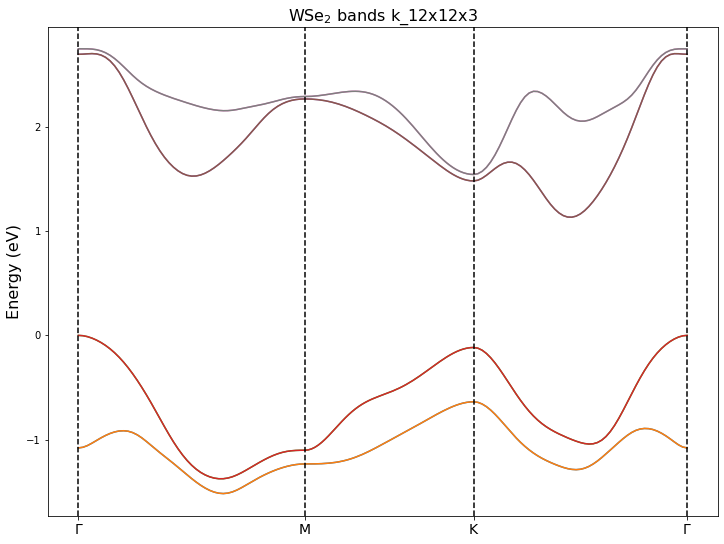

In [40]:
ind = 0

bands = U.BandStructure.from_Ypp(results[ind],high_sym,suffix='bands_interpolated')
fig, ax = plt.subplots(figsize=(12, 9))
bands.plot(plt,linestyle='-')
ax.set_ylabel('Energy (eV)',size=16)
plt.title('WSe$_2$ bands k_%s'%kpoints[ind],size=16)

__We perform the computation in the 9x9x1 using the same parameters of the bands computation in the RT case
with elph coupling.__

In [8]:
run_path = 'BANDS'
kpoints = '9x9x1'

In [9]:
source_dir = 'PHONON/nscf/WSe2.save'
run_dir = os.path.join(run_path,kpoints)
Tools.init_yambo_dir(input_dir=source_dir,yambo_dir=run_dir)

Create the folder path BANDS/9x9x1
Executing command: cd BANDS/9x9x1; p2y -I ../../PHONON/nscf/WSe2.save
Build the r_setup in the yambo_dir path BANDS/9x9x1


In [10]:
band_range = [49,54]
bands_step = 50
scissor = 0.261 # eV

# The coordinates of the high sym points are provided in crystal coordinates
# to match the 'rlu' in the ypp input
G = [0.,0.,0.]
K = [1./3.,1./3.,0.]
M = [0.5,0.,0.]
high_sym = {'G':G,'K':K,'M':M} # useful to label the high-sym point on the path

study = D.Dataset(num_tasks=1,skip=True)

inp = I.YamboInput(args='ypp -s b -V qp',folder=run_dir,filename='ypp.in')
inp.set_array_variables(BANDS_bands=band_range,BANDS_steps=bands_step)
inp.set_array_variables(GfnQP_E=[scissor,1.,1.])
inp.set_scalar_variables(cooIn='rlu',cooOut='rlu')
inp.set_scalar_variables(BANDS_path='G M K G',INTERP_mode='BOLTZ')
inp['variables']['INTERP_Shell_Fac'] = [20,'']
idd = 'ypp_bands_dft_rt-parameters'
study.append_run(run_dir=run_dir,id=idd,input=inp,runner=ypp_code) 

Initialize a Dataset with 1 parallel tasks


In [11]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'BANDS/9x9x1',
 'num_tasks': 1,
 'verbose': True,
 'skip': True,
 'input': {'args': 'ypp -s b -V qp',
  'folder': 'BANDS/9x9x1',
  'filename': 'ypp.in',
  'arguments': [],
  'variables': {'INTERP_Shell_Fac': [20, ''],
   'INTERP_NofNN': [1.0, ''],
   'OutputAlat': [0.0, ''],
   'BANDS_steps': [50, ''],
   'GfnQP_INTERP_NN': [1.0, ''],
   'GfnQP_INTERP_shells': [20.0, ''],
   'GfnQP_Wv_E': [0.0, 'eV'],
   'GfnQP_Wv_dos': [0.0, 'eV'],
   'GfnQP_Wc_E': [0.0, 'eV'],
   'GfnQP_Wc_dos': [0.0, 'eV'],
   'PROJECT_mode': 'none',
   'INTERP_mode': 'BOLTZ',
   'cooIn': 'rlu',
   'cooOut': 'rlu',
   'CIRCUIT_E_DB_path': 'none',
   'GfnQPdb': 'none',
   'GfnQP_DbGd_INTERP_mode': 'NN',
   'GfnQP_Z': [(1+0j), ''],
   'BANDS_bands': [[49, 54], ''],
   'GfnQP_E': [[0.261, 1.0, 1.0], ''],
   'GfnQP_Wv': [[0.0, 0.0, 0.0], ''],
   'GfnQP_Wc': [[0.0, 0.0, 0.0], ''],
   'BANDS_path': 'G M K G'}},
 'name': 'ypp_bands_dft_rt-parameters'}

In [12]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 ypp -F ypp_bands_dft_rt-parameters.in -J ypp_bands_dft_rt-parameters -C ypp_bands_dft_rt-parameters
slurm submit:  cd BANDS/9x9x1 ; sbatch job_ypp_bands_dft_rt-parameters.sh
computation ypp_bands_dft_rt-parameters is running...
computation ypp_bands_dft_rt-parameters ended
Task [0] ended 
 


Text(0.5, 1.0, 'WSe$_2$ bands k_9')

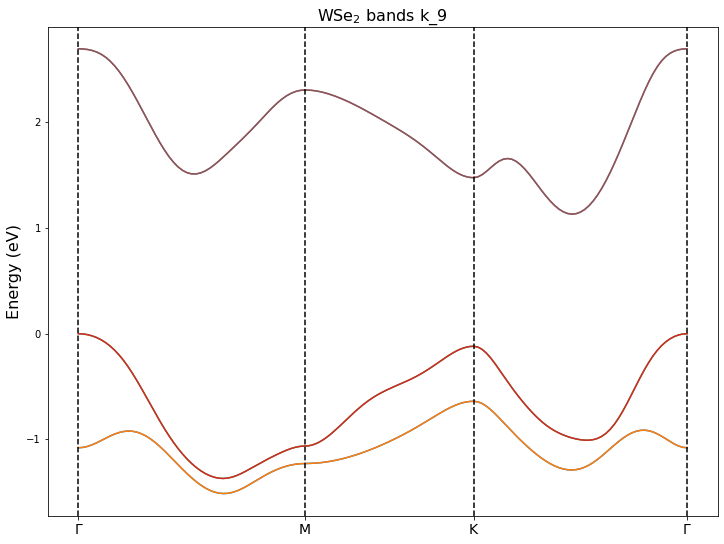

In [13]:
ind = 0

bands = U.BandStructure.from_Ypp(results[ind],high_sym,suffix='bands_interpolated')
fig, ax = plt.subplots(figsize=(12, 9))
bands.plot(plt,linestyle='-')
ax.set_ylabel('Energy (eV)',size=16)
plt.title('WSe$_2$ bands k_%s'%kpoints[ind],size=16)

## Dependence of the band structure on the _vertical_ k component

We analyze the dependece of the band structure properties on the value of the k component orthogonal to the 

In [10]:
source_dir = 'DFT_analysis/kpoints_12x12x3-nbnds_60.save'
run_dir = 'BANDS/12x12x3'
Tools.init_yambo_dir(input_dir=source_dir,yambo_dir=run_dir)

SAVE folder BANDS/12x12x3/SAVE already present. No operations performed.


In [56]:
band_range = [49,54]
bands_step = 50
scissor = 0.261 # eV

inp = I.YamboInput(args='ypp -s b -V qp',folder=run_dir,filename='ypp.in')
inp.set_array_variables(BANDS_bands=band_range,BANDS_steps=bands_step)
inp.set_array_variables(GfnQP_E=[scissor,1.,1.])
inp.set_scalar_variables(cooIn='rlu',cooOut='rlu')
inp['variables']['INTERP_Shell_Fac'] = [20,'']

study = D.Dataset(num_tasks=1,skip=True)

G = [0.,0.,0.]
K = [1./3.,1./3.,0.]
M = [0.5,0.,0.]
high_sym_0 = {'G':G,'K':K,'M':M} # useful to label the high-sym point on the path
inp.set_array_variables(BANDS_kpts=[G,M,K,G])
inp.set_scalar_variables(INTERP_mode='BOLTZ')
#inp.set_scalar_variables(BANDS_path='G M K G',INTERP_mode='BOLTZ')
idd = 'ypp_bands_dft_kvert=0'
study.append_run(run_dir=run_dir,id=idd,input=inp,runner=ypp_code) 

G = [0.,0.,1/3.]
K = [1./3.,1./3.,1/3.]
M = [0.5,0.,1/3.]
high_sym_1 = {'G':G,'K':K,'M':M} # useful to label the high-sym point on the path
inp.set_array_variables(BANDS_kpts=[G,M,K,G])
inp.set_scalar_variables(INTERP_mode='BOLTZ')
idd = 'ypp_bands_dft_kvert=3m1'
study.append_run(run_dir=run_dir,id=idd,input=inp,runner=ypp_code) 

G = [0.,0.,0.1]
K = [1./3.,1./3.,0.1]
M = [0.5,0.,0.1]
high_sym_2 = {'G':G,'K':K,'M':M} # useful to label the high-sym point on the path
inp.set_array_variables(BANDS_kpts=[G,M,K,G])
inp.set_scalar_variables(INTERP_mode='BOLTZ')
idd = 'ypp_bands_dft_kvert=0p1'
study.append_run(run_dir=run_dir,id=idd,input=inp,runner=ypp_code) 

Initialize a Dataset with 1 parallel tasks


In [53]:
#study.runs[2]

In [54]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of ypp_bands_dft_kvert=0
Task [0] ended 
 
Run the task [1] 
Skip the run of ypp_bands_dft_kvert=3m1
Task [1] ended 
 
Run the task [2] 
run command: mpirun -np 32 ypp -F ypp_bands_dft_kvert=0p1.in -J ypp_bands_dft_kvert=0p1 -C ypp_bands_dft_kvert=0p1
slurm submit:  cd BANDS/12x12x3 ; sbatch job_ypp_bands_dft_kvert=0p1.sh
computation ypp_bands_dft_kvert=0p1 is running...
computation ypp_bands_dft_kvert=0p1 ended
Task [2] ended 
 


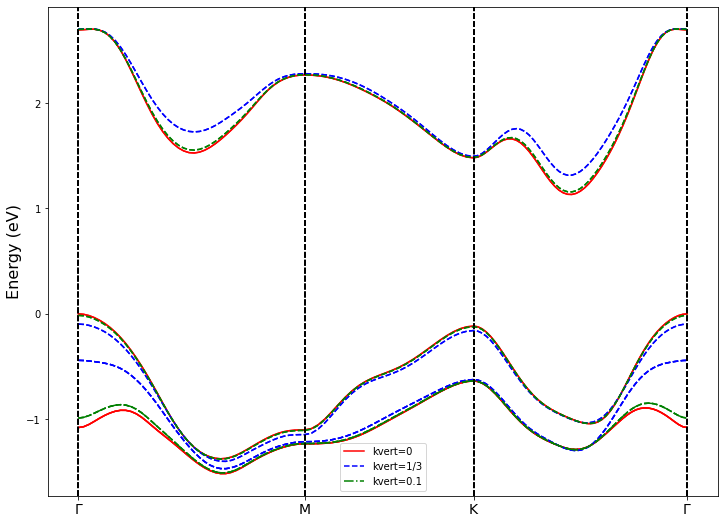

In [57]:
ind = 1

bands_0 = U.BandStructure.from_Ypp(results[0],high_sym_0,suffix='bands_interpolated')
bands_1 = U.BandStructure.from_Ypp(results[1],high_sym_1,suffix='bands_interpolated')
bands_2 = U.BandStructure.from_Ypp(results[2],high_sym_2,suffix='bands_interpolated')


fig, ax = plt.subplots(figsize=(12, 9))
bands_0.plot(plt,selection=[0],linestyle='-',c='r',label='kvert=0')
bands_0.plot(plt,linestyle='-',c='r')
bands_1.plot(plt,selection=[0],linestyle='--',c='b',label='kvert=1/3')
bands_1.plot(plt,linestyle='--',c='b')
bands_2.plot(plt,selection=[0],linestyle='-.',c='green',label='kvert=0.1')
bands_2.plot(plt,linestyle='--',c='green')
ax.set_ylabel('Energy (eV)',size=16)
plt.legend()
#plt.title('WSe$_2$ bands k_%s'%kpoints[ind],size=16)

In [68]:
DOS_steps = 1000
DOSERange = [-2.,2.] # eV
DOS_broad = 0.05 # eV
scissor = 0.261 # eV

study = D.Dataset(num_tasks=1,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('ypp -s s -V All',folder=run_dir,filename='ypp.in')
inp.set_array_variables(DOSESteps=DOS_steps,GfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='eV',DOS_broad=DOS_broad,DOSERange=DOSERange)
idd = 'dos-test'
study.append_run(run_dir=run_dir,id=idd,input=inp,runner=ypp_code) 

Initialize a Dataset with 1 parallel tasks


In [69]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of dos-test
Task [0] ended 
 


In [74]:
data = results[0].data['el_dos']
energy = data['col1']
dos = data['col4']

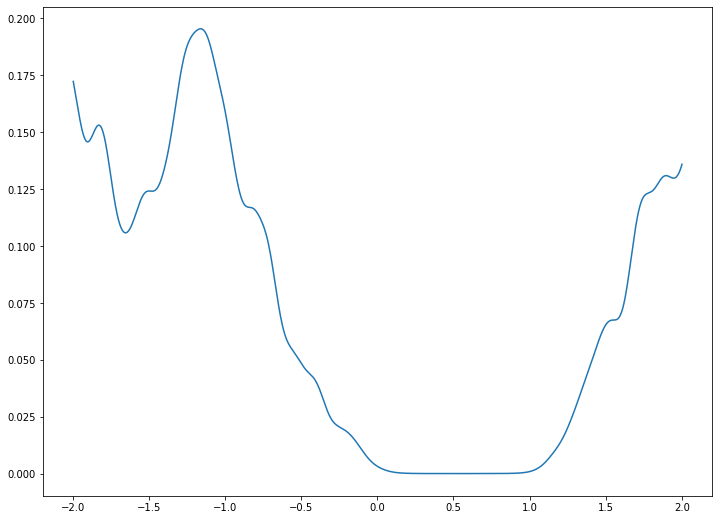

In [75]:
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(energy,dos)